# コンスタレーション

In [82]:
#import
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

sys.path.append('../')
from pyopt.util import save_pickle, load_pickle

# 1. ANN定義

In [5]:
def data_shaping(input_signal, signal, max_tap, tap):
    """
    input_signal: 伝送前の信号
    signal: 伝送後の信号
    max_tap: 最大の同時入力シンボル数
    tap: 同時入力シンボル数
    
    signal = [x_0, x_1, ... , x_(n-1)]
      |
      |
      v
    x = [[x_0, x_1, ... , x_tap-1],
            [x_1, x_2, ..., x_tap],
                   .
                   .
                   .
            [x_(n-tap), x_(n-tap+1), ..., x(n-1)]]
      |
      |
      v
    x = [[i_0, q_0, i_1, q_1, ... , i_(tap-1), q_(tap-1)],
            [i_1, q_1, i_2, q_2, ... , i_tap, q_tap],
                   .
                   .
                   .
            [i_(n-tap), q_(n-tap), i_(n-tap+1), q_(n-tap+1), ..., i_(n-1), q_(n-1)]] (batch, input_dim) input_dim = tap * 2
    
    y  (batch, output_dim) output_dim = 2
    """
    
    x = np.zeros((len(input_signal) - (max_tap - 1), tap * 2), dtype=float)
    y = np.zeros((len(input_signal) - (max_tap - 1), 2), dtype=float)
    for i, j in enumerate(np.arange(max_tap // 2, len(input_signal) - max_tap // 2)):
        x[i, 0::2] = signal[j - tap // 2: j + tap // 2 + 1].real
        x[i, 1::2] = signal[j - tap // 2: j + tap // 2 + 1].imag
        y[i, 0] = input_signal[j].real
        y[i, 1] = input_signal[j].imag
    return x, y

In [6]:
class Dataset(data.Dataset):
    def __init__(self, x, y, mean, std):
        self.x, self.y, self.mean, self.std = x, y, mean, std
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        x = self.x[index]
        y = self.y[index]
        
        x = (x - self.mean) / self.std
        y = (y - self.mean) / self.std
        return torch.Tensor(x), torch.Tensor(y)

In [7]:
class ANN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_neuron):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_neuron)
        self.fc2 = nn.Linear(hidden_neuron, output_dim)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [8]:
def evm_score(y_pred, y_true):
    tmp = 0
    for i in range(len(y_pred)):
        tmp += ((y_pred[i][0] - y_true[i][0]) ** 2 + (y_pred[i][1] - y_true[i][1]) ** 2) / (y_true[i][0] ** 2 + y_true[i][1] ** 2)
    evm = torch.sqrt(tmp / len(y_pred))
    return evm

In [9]:
def train_model(device, model, dataloaders_dict, criterion, optimizer, epochs, epochs_section=None):
    for epoch in range(epochs):
        if epochs_section is not None:
            epoch += epochs_section[0]
            end_epoch = epochs_section[1]
        else:
            end_epoch = epochs
        
        start_time = time.time()
        
        for phase in dataloaders_dict.keys():
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            epoch_loss = 0.0
            epoch_evms = 0.0
            
            for x, y in dataloaders_dict[phase]:
                x = x.to(device)
                y = y.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(x)
                    loss = criterion(outputs, y)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                    epoch_loss += loss.item() * x.size(0)
                    epoch_evms += (evm_score(outputs, y)) ** 2 * x.size(0)
            
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_evm = torch.sqrt(epoch_evms / len(dataloaders_dict[phase].dataset)) * 100
            
            duration = str(datetime.timedelta(seconds=time.time() - start_time))[:7]
            print('{} | Epoch: {}/{} | {} Loss: {:.4} | EVM: {:.4}'.format(duration, epoch + 1, end_epoch, phase, epoch_loss, epoch_evm))
    return model

# 2. 可視化

## 2.1 データ読み込み

In [74]:
def prepare_val_data(N, image_number='0', signal_type='image'):
    # t_condition 伝送条件
    signal_type = 'image'
    form = 'RZ16QAM'  # 変調方式
    n = 32  # 1シンボルあたりのサンプリング数[/symbol]
    equalize = False  # 各シンボル数を均等にするか
    baudrate = 28  # ボーレート[GBaud]
    PdBm = 1  # 平均入力光パワー[dBm]
    Ledfa = 100  # EDFAスパン[km]
    stepedfa = 30  # SSFMの繰り返し計算ステップ数
    gamma = 1.4  # 非線形係数[/W/km]
    D = 16  # 分散パラメータ[ps/nm/km]
    Alpha = 0.16  # 伝送損失[dB/km]
    NF = 4  # ASE雑音指数[dB]
    Lmax = 500  # 伝送距離[km]
    ase = True  # ASE雑音を考慮するか
    if signal_type == 'prbs':
        # N = 13  # PRBSの次数
        itr = 1  # PRBSの繰り返し回数
    elif signal_type == 'random':
        seed = 1234  # 乱数シード
        bit_num = 10000  # ビット長を指定
    elif signal_type == 'image':
        target_dir = 'train'
        step = 10  # =10 ---> (768, 1024) ---> (76, 102)
        image_number = '0'
        ebtb = True  # 8B10Bを行うか

    # prbs.csv or random.csv or image.csvの列指定に用いる文字列
    t_condition = 'form=="'+str(form)+'"&n=='+str(n)+'&equalize=='+str(equalize)+'&baudrate=='+str(baudrate)+'&PdBm=='+str(PdBm)+'&Ledfa=='+str(Ledfa)+'&stepedfa=='+str(stepedfa)+'&\
                            gamma=='+str(gamma)+'&D=='+str(D)+'&Alpha=='+str(Alpha)+'&NF=='+str(NF)+'&ase=='+str(ase)
    if signal_type == 'prbs':
        condition = 'N=='+str(N)+'&itr=='+str(itr)
    elif signal_type == 'random':
        condition = 'seed=='+str(seed)+'&bit_num=='+str(bit_num)
    elif signal_type == 'image':
        condition = 'target_dir=="'+target_dir+'"&step=='+str(step)+'&image_number=="'+image_number+'"&ebtb=='+str(ebtb)

    # prbs.csv or random.csv or image.csvをpandasで読み込む
    t_df_dir = '../data/input/'
    t_df = pd.read_csv(t_df_dir+signal_type+'.csv', index_col=0)

    # prbs.csv or random.csv or image.csvにおいて、指定した伝送条件を見たす行を抜き出す
    t_query = t_df.query(condition + '&' + t_condition)

    # 伝送信号を入力データに整形する
    sgnl = load_pickle(t_query.iloc[0]['data_path'])
    lc = sgnl.linear_compensation(Lmax, sgnl.signal['x_' + str(Lmax)])
    x, y = data_shaping(sgnl.signal['x_0'][n//2::n], lc[n//2::n], max_tap, tap)
    return x, y

## 2.2 Model読み込み

In [80]:
device = torch.device('cpu') # 'cuda' if torch.cuda.is_available() else 
print('Device available now:', device)

# l_condition 学習条件
tap = 1
max_tap = 501
batch_size = 100
neuron = 300
epochs = 100
lr = 0.001

# t_condition 伝送条件
signal_type = 'image'
form = 'RZ16QAM'  # 変調方式
n = 32  # 1シンボルあたりのサンプリング数[/symbol]
equalize = False  # 各シンボル数を均等にするか
baudrate = 28  # ボーレート[GBaud]
PdBm = 1  # 平均入力光パワー[dBm]
Ledfa = 100  # EDFAスパン[km]
stepedfa = 30  # SSFMの繰り返し計算ステップ数
gamma = 1.4  # 非線形係数[/W/km]
D = 16  # 分散パラメータ[ps/nm/km]
Alpha = 0.16  # 伝送損失[dB/km]
NF = 4  # ASE雑音指数[dB]
Lmax = 500  # 伝送距離[km]
ase = True  # ASE雑音を考慮するか
if signal_type == 'prbs':
    N = 13  # PRBSの次数
    itr = 1  # PRBSの繰り返し回数
elif signal_type == 'random':
    seed = 1234  # 乱数シード
    bit_num = 10000  # ビット長を指定
elif signal_type == 'image':
    target_dir = 'train'
    step = 10  # =10 ---> (768, 1024) ---> (76, 102)
    image_number = '0'
    ebtb = True  # 8B10Bを行うか

# ANN.csvの列指定に用いる文字列
l_condition = 'tap=='+str(tap)+'&max_tap=='+str(max_tap)+'&batch_size=='+str(batch_size)+'&neuron=='+str(neuron)+'&learning_rate=='+str(lr)
t_condition = 'form=="'+str(form)+'"&n=='+str(n)+'&equalize=='+str(equalize)+'&baudrate=='+str(baudrate)+'&PdBm=='+str(PdBm)+'&Ledfa=='+str(Ledfa)+'&stepedfa=='+str(stepedfa)+'&\
                        gamma=='+str(gamma)+'&D=='+str(D)+'&Alpha=='+str(Alpha)+'&NF=='+str(NF)+'&ase=='+str(ase)
if signal_type == 'prbs':
    condition = 'N=='+str(N)+'&itr=='+str(itr)
elif signal_type == 'random':
    condition = 'seed=='+str(seed)+'&bit_num=='+str(bit_num)
elif signal_type == 'image':
    condition = 'target_dir=="'+target_dir+'"&step=='+str(step)+'&image_number=="'+image_number+'"&ebtb=='+str(ebtb)

# ANN.csvをpandasで読み込む
l_df_dir = '../data/params/ANN.csv'
l_df = pd.read_csv(l_df_dir, index_col=0)

# ANN.csvにおいて、指定した条件を満たす行だけqueryとして抜き出す
l_query = l_df.query(l_condition + '&' + condition + '&' + t_condition + '&Lmax=='+str(Lmax))

if len(l_query) == 0 or l_query['epochs'].max() < epochs:
    print('指定された条件の学習結果は存在しません')
else:
    index = l_query[l_query['epochs']==epochs].index
    model = ANN(input_dim=tap*2, output_dim=2, hidden_neuron=neuron).to(device)
    model.load_state_dict(torch.load(l_query['params_path'][index].values[0]))

x, y = prepare_val_data(N=13, image_number=image_number, signal_type=signal_type)
mean = np.mean(x)
std = np.std(x)

Device available now: cpu


## 2.3 表示

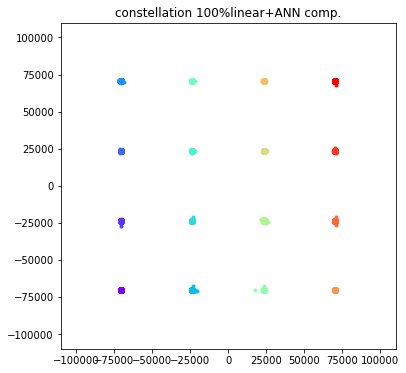

In [84]:
x, y = prepare_val_data(N=13, image_number='0', signal_type='prbs')
dataset = Dataset(x=x, y=y, mean=mean, std=std)
dataloader = data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

annc = model(dataset[:][0]).detach().numpy()
annc = annc * std + mean
annc = annc[:, 0] + annc[:, 1] * 1j
y_complex = y[:, 0] + y[:, 1] * 1j

symbol, inverse, counts = np.unique(y_complex, return_inverse=True, return_counts=True)

lim = 110000
cm = plt.get_cmap('rainbow', 16)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)

for i in range(len(symbol)):
    ax.plot(annc[y_complex == symbol[i]].real, annc[y_complex == symbol[i]].imag, '.', color=[cm(i)[0], cm(i)[1], cm(i)[2]])
for i in range(len(symbol)):
    ax.plot(y_complex[y_complex == symbol[i]].real, y_complex[y_complex == symbol[i]].imag, 'o', color=[cm(i)[0], cm(i)[1], cm(i)[2]])
ax.set_title('constellation 100%linear+ANN comp.')
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim);

In [47]:
l_df = pd.read_csv(l_df_dir, index_col=0)
for i in range(len(l_df)):
    t = l_df.iloc[i]['image_number']
    t2 = ''
    for j in range(1, len(t), 3):
        if j == 1:
            t2 = t2 + t[j]
        else:
            t2 = t2 + ', ' + t[j]
        l_df['image_number'].loc[i] = t2
print(l_df['image_number'])
l_df.to_csv(l_df_dir)

0       0
1       0
2    0, 1
3    0, 1
Name: image_number, dtype: object
